In [ ]:
"""
Notebook for training the embedding model for the flow around cylinder system.
=====
Distributed by: Notre Dame SCAI Lab (MIT Liscense)
- Associated publication:
url: https://arxiv.org/abs/2010.03957
doi: 
github: https://github.com/zabaras/transformer-physx
=====
"""
!nvidia-smi

Thu Jul 29 01:21:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Environment Setup

Use pip to install from [PyPI](https://pypi.org/project/trphysx/).

In [ ]:
!pip install trphysx==0.0.7

     |████████████████████████████████| 137 kB 9.8 MB/s 


Mount google drive and create a folder to work in.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/
% mkdir -p transformer_physx/cylinder
% cd transformer_physx/cylinder

/content/gdrive/MyDrive
/content/gdrive/MyDrive/transformer_physx/cylinder


Now lets download the training and validation data for the cylinder system. This will eventually be update to zenodo repo.

In [ ]:
!mkdir data

**WARNING: Training datafile is 1.3Gb! Validation is 0.35Gb!** These will be stored in your Google drive!

Because this is a big datafile, we will use gdown to instead of wget because of virus warning from google drive.

In [ ]:
!pip install gdown
import gdown
import os
if not os.path.exists("./data/cylinder_training.hdf5"):
  gdown.download("https://drive.google.com/uc?id=1i6ObgR4GsSMRBJ16rdMvexgU2egKYT3v", "./data/cylinder_training.hdf5", quiet=False)
if not os.path.exists("./data/cylinder_valid.hdf5"):
  gdown.download("https://drive.google.com/uc?id=10I_uqaKgq82IxTKiRnaJ39Ajpe4e8Rws", "./data/cylinder_valid.hdf5", quiet=False)
# !wget -O ./data/cylinder_training.hdf5 "https://drive.google.com/uc?id=1i6ObgR4GsSMRBJ16rdMvexgU2egKYT3v"
# !wget -O ./data/cylinder_valid.hdf5 "https://drive.google.com/uc?id=10I_uqaKgq82IxTKiRnaJ39Ajpe4e8Rws"

Downloading...
From: https://drive.google.com/uc?id=1i6ObgR4GsSMRBJ16rdMvexgU2egKYT3v
To: /content/gdrive/MyDrive/transformer_physx/cylinder/data/cylinder_training.hdf5
1.29GB [00:23, 54.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=10I_uqaKgq82IxTKiRnaJ39Ajpe4e8Rws
To: /content/gdrive/My Drive/transformer_physx/cylinder/data/cylinder_valid.hdf5
342MB [00:09, 36.3MB/s]


# Transformer-PhysX Cylinder System

Train the embedding model.
First import necessary modules from trphysx. 

In [ ]:
import sys
import logging

import torch
from torch.optim.lr_scheduler import ExponentialLR

from trphysx.config.configuration_auto import AutoPhysConfig
from trphysx.embedding.embedding_auto import AutoEmbeddingModel
from trphysx.viz.viz_auto import AutoViz
from trphysx.embedding.training import *

logger = logging.getLogger(__name__)

Training arguments.

In [ ]:
argv = []
argv = argv + ["--exp_name", "cylinder"]
argv = argv + ["--training_h5_file", "./data/cylinder_training.hdf5"]
argv = argv + ["--eval_h5_file", "./data/cylinder_valid.hdf5"]
argv = argv + ["--batch_size", "32"]
argv = argv + ["--block_size", "4"]
argv = argv + ["--n_train", "27"]
argv = argv + ["--n_eval", "6"]
argv = argv + ["--epochs", "100"]

In [ ]:
args = EmbeddingParser().parse(args=argv)  

# Setup logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO)

if(torch.cuda.is_available()):
    use_cuda = "cuda"
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info("Torch device: {}".format(args.device))

07/29/2021 01:24:46 - INFO - __main__ -   Torch device: cuda:0


## Initializing Datasets and Models

Now we can use the auto classes to initialized the predefined configs, dataloaders and models. This may take a bit!

In [ ]:
# Load transformer config file
config = AutoPhysConfig.load_config(args.exp_name)
data_handler = AutoDataHandler.load_data_handler(args.exp_name)
viz = AutoViz.load_viz(args.exp_name, plot_dir=args.plot_dir)

  # Set up data-loaders
training_loader = data_handler.createTrainingLoader(
                        args.training_h5_file, 
                        block_size=args.block_size, 
                        stride=args.stride, 
                        ndata=args.n_train, 
                        batch_size=args.batch_size)
testing_loader = data_handler.createTestingLoader(
                    args.eval_h5_file, 
                    block_size=32, 
                    ndata=args.n_eval, 
                    batch_size=8)

# Set up model
model = AutoEmbeddingModel.init_trainer(args.exp_name, config).to(args.device)
mu, std = data_handler.norm_params
model.embedding_model.mu = mu.to(args.device)
model.embedding_model.std = std.to(args.device)
if args.epoch_start > 1:
    model.load_model(args.ckpt_dir, args.epoch_start)

07/29/2021 01:25:09 - INFO - root -   Creating training loader
07/29/2021 01:25:46 - INFO - root -   Creating testing loader
07/29/2021 01:25:53 - WARNING - root -   Lower batch-size to 6
07/29/2021 01:25:53 - INFO - trphysx.embedding.embedding_cylinder -   Number of embedding parameters: 262535


Initialize optimizer and scheduler. Feel free to change if you want to experiment.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr*0.995**(args.epoch_start-1), weight_decay=1e-8)
scheduler = ExponentialLR(optimizer, gamma=0.995)

## Training the Embedding Model

This notebook only trains for 100 epochs for brevity, feel free to train longer. The test loss here is only the recovery loss MSE(x - decode(encode(x))) and does not reflect the quality of the Koopman dynamics.

In [ ]:
trainer = EmbeddingTrainer(model, args, (optimizer, scheduler), viz)
trainer.train(training_loader, testing_loader)

07/29/2021 01:28:26 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 1: Training loss 1137.899, Lr 0.00100
07/29/2021 01:28:28 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 1: Test loss: 0.02
07/29/2021 01:28:33 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 2: Training loss 197.960, Lr 0.00099
07/29/2021 01:28:39 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 3: Training loss 87.815, Lr 0.00099
07/29/2021 01:28:45 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 4: Training loss 62.818, Lr 0.00099
07/29/2021 01:28:51 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 5: Training loss 49.672, Lr 0.00098
07/29/2021 01:28:52 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 5: Test loss: 0.01
07/29/2021 01:28:58 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 6: Training loss 41.724, Lr 0.00098
07/29/2021 01:29:04 - INFO - trphysx.embedding.training.enn_trainer -   Epoch 7: Training loss 37.603, Lr 0.00097
07/29

Check your Google drive for checkpoints.

## Visualization of Results

Embed some test predictions of the embedding model, this is simply showing the prediction of the model of one Koopman step. I.e. x(t+1) = decoder(K*encoder(x(t))). Random time-steps are plotted.

Validation prediction for epoch: 1


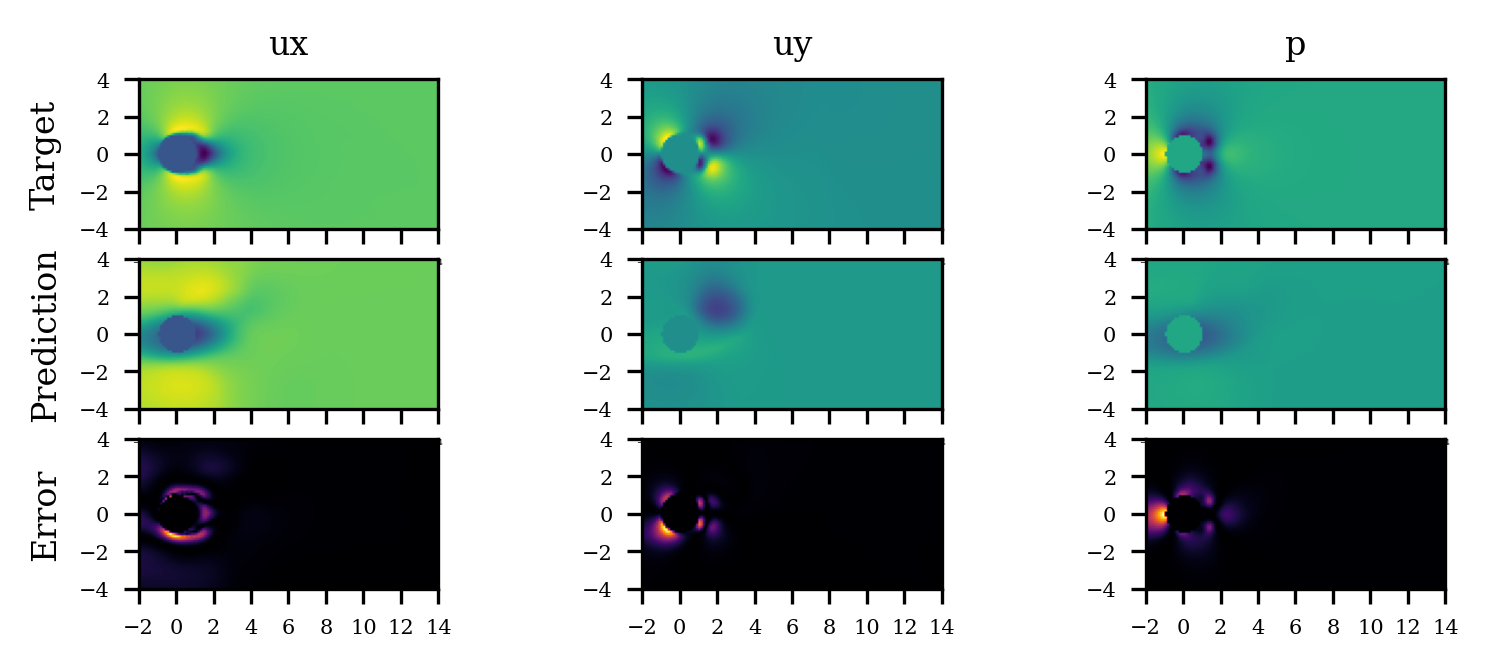

Validation prediction for epoch: 25


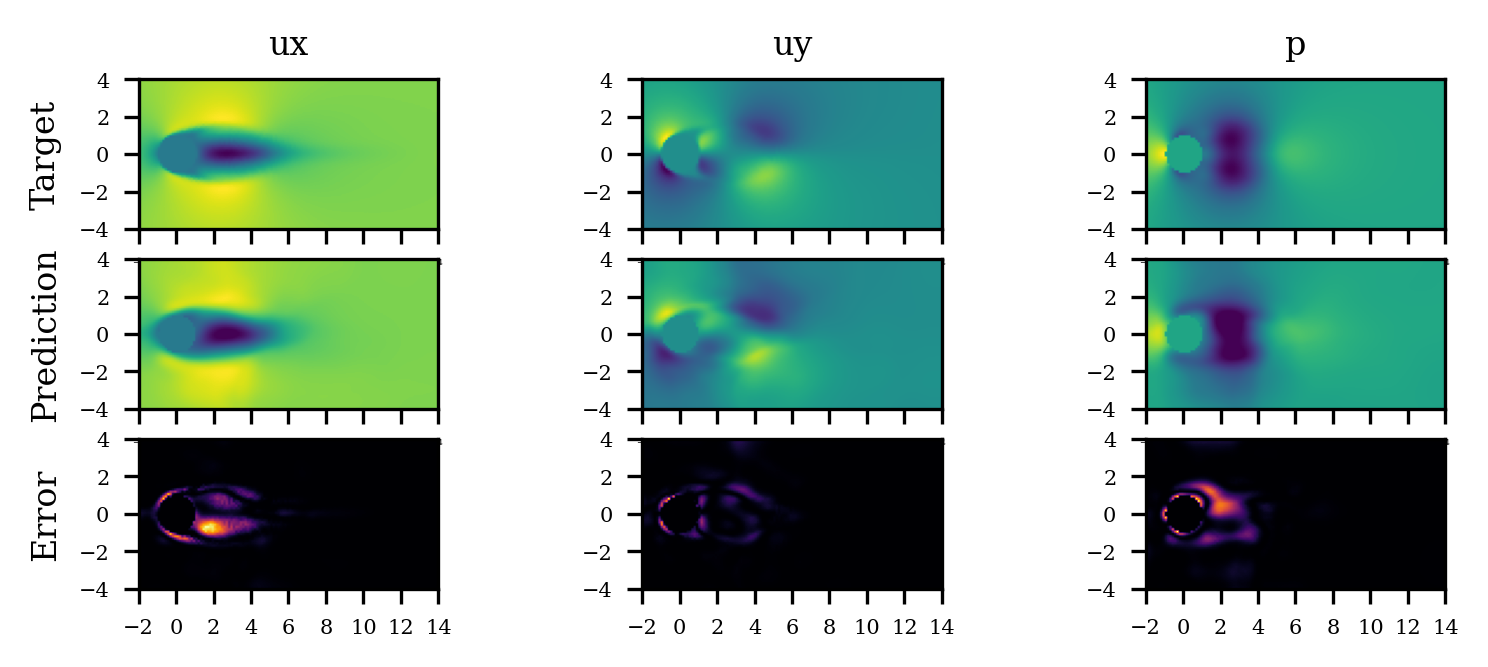

Validation prediction for epoch: 50


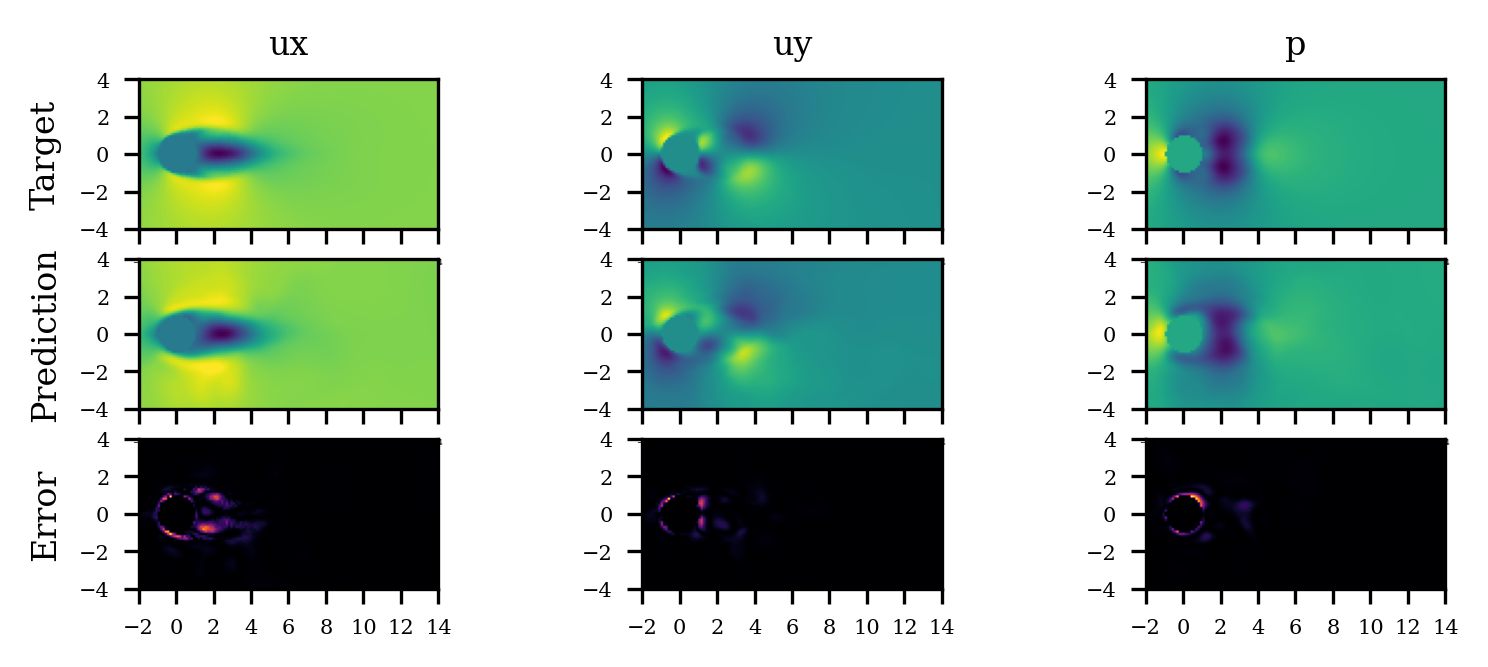

Validation prediction for epoch: 75


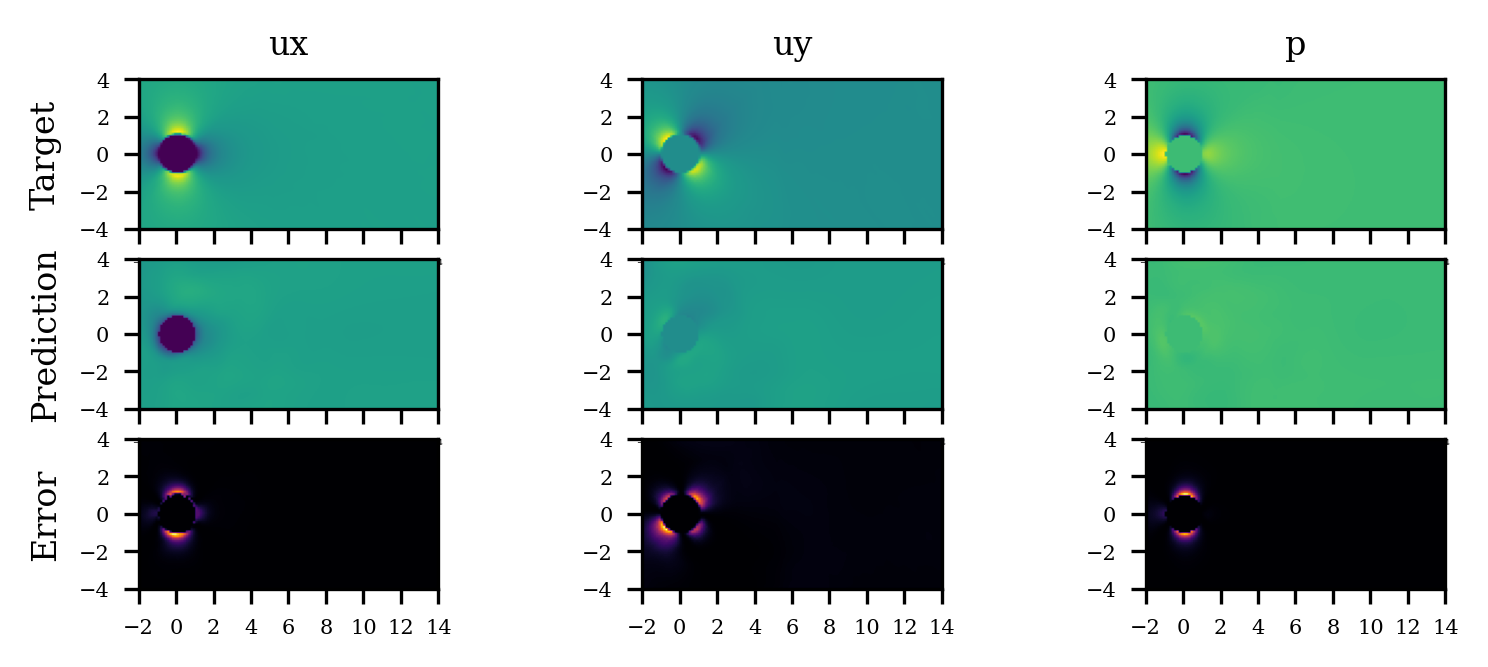

Validation prediction for epoch: 100


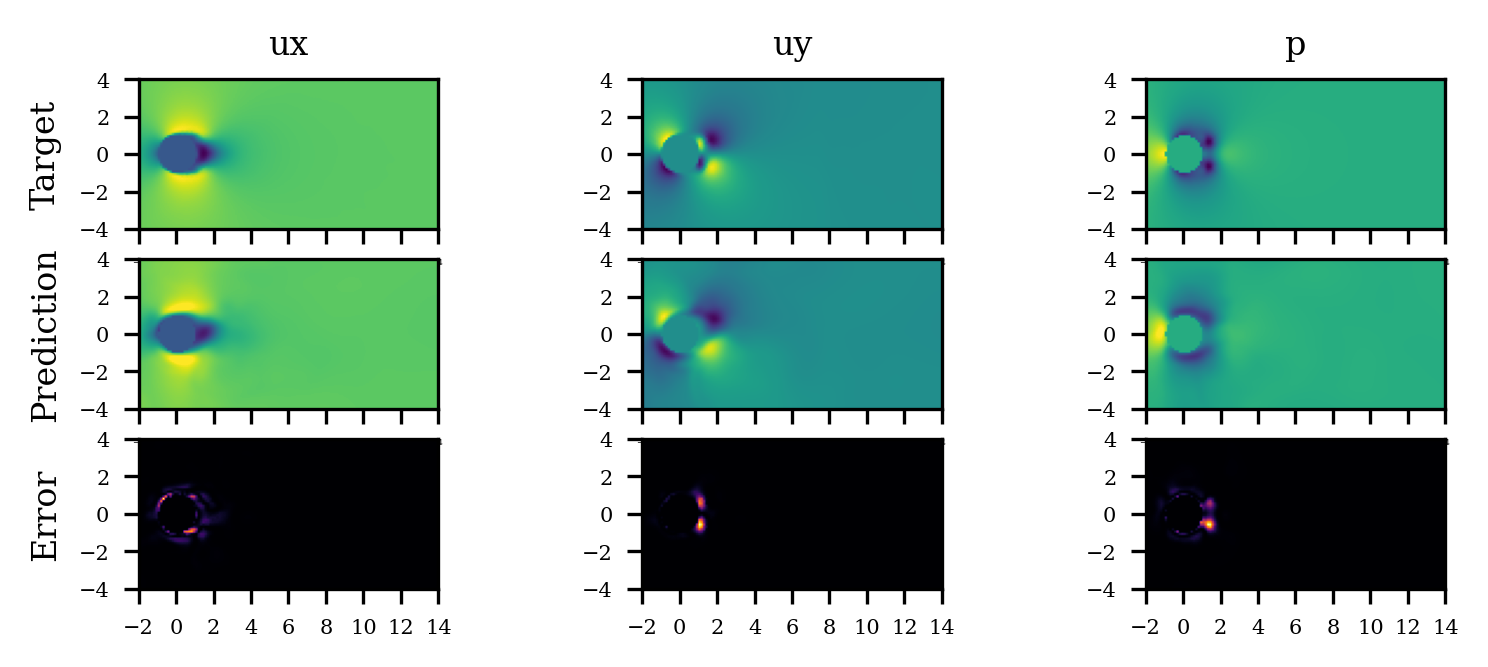

In [ ]:
from IPython.display import Image, display

for epoch in [1, 25, 50, 75, 100]:
  print('Validation prediction for epoch: {:d}'.format(epoch))
  file_path = './outputs/embedding_cylinder/ntrain27_epochs100_batch32/predictions/embeddingPred0_{:d}.png'.format(epoch)
  display(Image(file_path, width=600, height=300))